## import dependencies

In [1]:
import numpy as np
import landlab
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator
from landlab.components import DepressionFinderAndRouter
from landlab.components import ErosionDeposition
from landlab.components import FastscapeEroder
from landlab.io import read_esri_ascii
from landlab.io.esri_ascii import write_esri_ascii
from landlab import Component

In [2]:
class Shear_Stress(Component): #classe do componente criado
    
    _name = "Shear_Stress"
    
    #parametros iniciais do objeto 
    def __init__(self, dem, fluid_density=1000,sediment_density=2650, g=9.80665, mannings_n=0.05, k_w=2.5, runoff=1, k_Q=2.5e-07, b_sp=0.5, c_sp=1):
                        
        self._dem = dem
        self._runoff = runoff #The rate of excess overland flow production at each node (i.e.,rainfall rate less infiltration).
        self._k_Q = k_Q   #Prefactor on A**c_sp to give discharge.
        self._b_sp = b_sp #Power on drainage area to give channel width.
        self._c_sp = c_sp # Power on drainage area to give discharge.
        self._g = g  #gravidade 
        self._k_w = k_w   #Prefactor on A**b_sp to give channel width.
        self._mannings_n = mannings_n
        self._fluid_density = fluid_density
        # pgd da formula do shear stress
        self._shear_stress_coeficient_p1 = self._fluid_density #* self._g #* (self._mannings_n / self._k_w) ** 0.6 
        # segunda parte da formula
        self._shear_stress_coeficient_p2 = 0.6 * (1.0 - self._b_sp) #remover no rearranjo 
    
    def discrete_shear_stress(self, ss): # divisao do shear stress para escala de tamnhos da escala de Roux (1998)
    
        if ss <= 0:
            return 0
        if ss <= 1:
            return 1
        if ss <= 1.2710:
            return 1.2710
        if ss <= 1.7423:
            return 1.7423
        if ss <= 2.1964:
            return 2.1964
        if ss <= 2.8541:
            return 2.8541
        if ss <= 6.6074:
            return 6.6074
        if ss <= 14.503:
            return 14.503
        if ss <= 29.138:
            return 29.138
        if ss <= 58.275:
            return 58.275

        return 60

        
    def run_one_step(self):
        dem = self._dem
        node_z = dem.at_node["topographic__elevation"] #elevaçao
        node_A = dem.at_node["drainage_area"] #area de drenagem, vem do flow accumulator
        node_S = dem.at_node["topographic__steepest_slope"] #slope
        
        node_Q = self._k_Q * self._runoff * node_A ** self._c_sp # Calcula profundidade, parte que tem a ver com PAR_1, PAR_2 
        #shear stress usando a profundidade
        shear_stress_prefactor_timesAparts = (self._shear_stress_coeficient_p1 * node_Q ** self._shear_stress_coeficient_p2)
        counter=0
        
        while 1:
            
            #funçao clip atribui o valor zero a valores negativos que venham a ser encontrados
            #depressoes podem possuir valores negativos (lago, fosso, buraco negro)
            downward_slopes = node_S.clip(0.0) 
            slopes_tothe07 = downward_slopes ** 0.7
            shear_stress = shear_stress_prefactor_timesAparts * slopes_tothe07 #multiplica o pre fator do shear stress pelo slope e calcula o shear stress
            shear_stress_discrete = list(map(self.discrete_shear_stress, shear_stress)) #classifica os resultados anteriores com o intervalo definido
            
            #adiciona grid ao DEM
            if 'shear_stress' in mg.at_node.keys():
                mg.delete_field("node","shear_stress")

            mg.add_field("shear_stress", shear_stress, at="node", copy=True, clobber=False)
            
            if 'shear_stress_discrete' in mg.at_node.keys():
                mg.delete_field("node","shear_stress_discrete")
                
            mg.add_field("shear_stress_discrete", shear_stress_discrete, at="node", copy=True, clobber=False)
            
            self.d50 = (node_Q * slopes_tothe07) / 0.05
            self.d = node_Q
            self.S = slopes_tothe07
            
            break_flag = True
            if break_flag:
                    break


    def calc_d50(self):
        return self.d50




## import DEM

In [58]:
(mg_origin, z) = read_esri_ascii("./save_asc/testes_fse_7_8/ascii_fse_10_topographic__elevation.asc", name="topographic__elevation")


# (mg, z) = read_esri_ascii("./save_asc/testes_fse_7_8/ascii_fse_10_topographic__elevation.asc", name="topographic__elevation")
(mg, z) = read_esri_ascii("bacia_piratini_90m.asc", name="topographic__elevation")
mg.at_node.keys()

['topographic__elevation']

In [3]:
(mg_origin, z) = read_esri_ascii("./save_asc/testes_fse_7_8/ascii_fse_10_topographic__elevation.asc", name="topographic__elevation")


# (mg, z) = read_esri_ascii("./save_asc/testes_fse_7_8/ascii_fse_10_topographic__elevation.asc", name="topographic__elevation")
(mg, z) = read_esri_ascii("./save_asc/testes_fse_7_8/ascii_fse_10_topographic__elevation.asc", name="topographic__elevation")
mg.at_node.keys()

['topographic__elevation']

### show DEM

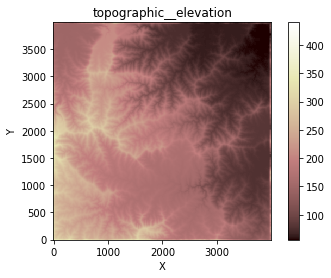

In [4]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation')

## create components

In [5]:
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
     mg,
     K_sp=.001,
     m_sp=.5,
     n_sp=1)
css = Shear_Stress(mg)
ed = ErosionDeposition(
     mg,
     K=0.00004, # Erodibility for substrate (units vary). talvez a mesma do fast scape (valor anterior = 0.00001)
     v_s=0.001, # Effective settling velocity for chosen grain size metric [L/T].
     m_sp=0.4, # Discharge exponent (units vary) usar valores do fast scape (valor anterior = 0.5)
     n_sp = 1.0, #Slope exponent (units vary) usar valores do fast scape
     sp_crit=0) #Critical stream power to erode substrate [E/(TL^2)] usar valores do fast scape

## run components 
> Burn in an initial drainage network using the Fastscape eroder:



In [6]:
mg.at_node['topographic__elevation'][0]

400.0

In [7]:
# Valor do fsc_dt deve ser entre 10y e 1000y 
fsc_dt= 1000 #passo de tempo do fast scape
ed_dt=1000 #Erosion deposition time step

for i in range(1):
    print(i)
    fr.run_one_step()
    df.map_depressions()
    flooded = np.where(df.flood_status==3)[0] # ver pra que serve
    fsc.run_one_step(dt = fsc_dt)
    mg.at_node['topographic__elevation'][0] -= 0.0 #uplift (nao sei pq ta fazendo isso, talvez nao precise) valor inicial era 0.001
   
    #parte abaixo eh do erosion deposision
    ed.run_one_step(dt = ed_dt)
    mg.at_node['topographic__elevation'][0] -= 2e-4 * ed_dt # Verificar se faz diferenca
    if i == 10 or i == 20 or i == 30:
        pass
#         files = write_esri_ascii("./save_asc/testes_fse_ed_7_8/ascii_fse_intercalado"+str(i)+".asc", mg)
        
css.run_one_step()

0


In [8]:
mg.at_node.keys()

['topographic__elevation',
 'water__unit_flux_in',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'sediment__flux',
 'shear_stress',
 'shear_stress_discrete']

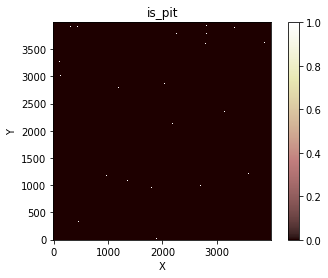

In [9]:
landlab.plot.imshow.imshow_grid_at_node(mg,'is_pit')

In [10]:
def classify_grain(size):
    if size <= 0.004:
        return 1
    if size <= 0.062:
        return 2
    if size <= 0.25:
        return 3
    if size <= 0.5:
        return 4
    if size <= 1:
        return 5
    if size <= 4:
        return 6
    
    return 7
    

In [11]:
grain_type = list(map(classify_grain, css.d50))

In [12]:
mg.add_field("cd50", grain_type, at="node", copy=True, clobber=False)

array([1, 1, 1, ..., 1, 1, 1])

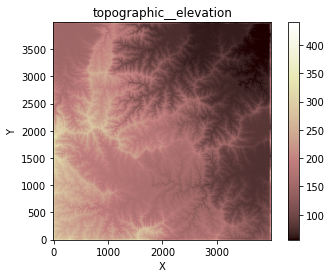

In [13]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation')

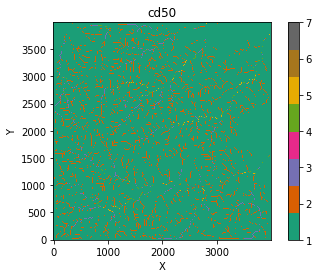

In [14]:
landlab.plot.imshow.imshow_grid_at_node(mg,'cd50', cmap='Dark2')

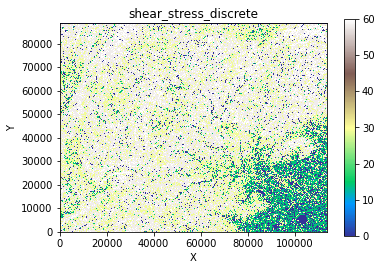

In [71]:
landlab.plot.imshow.imshow_grid_at_node(mg,'shear_stress_discrete', cmap='terrain')